In [1]:
'''
state space
0 |Cart Position | -4.8 4.8
1 |Cart Velocity |-Inf Inf 
2 |Pole Angle | ~ -0.418 rad (-24°) ~ 0.418 rad (24°) 
3 |Pole Angular Velocity |-Inf Inf
'''

'\nstate space\n0 |Cart Position | -4.8 4.8\n1 |Cart Velocity |-Inf Inf \n2 |Pole Angle | ~ -0.418 rad (-24°) ~ 0.418 rad (24°) \n3 |Pole Angular Velocity |-Inf Inf\n'

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder


class CartPoleEnv(gym.Env):

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self, render_mode="rgb_array", n_observations=1000, q_table=np.array(None), alpha=0.5):
      self.env = gym.make("CartPole-v1", render_mode=render_mode)
      self.action_space = self.env.action_space
      self.observation_space = self.env.observation_space
      self.n_observation_space = 4
      self.n_buckets = 4
      low = [-4.8, -50, -0.418, -50]
      self.bucket_size = np.array(low) / (self.n_buckets/2)
      self.q_table =  np.zeros((self.env.action_space.n, np.power(self.n_buckets, self.n_observation_space))) if not q_table.all() else q_table
      self.epsilon = 1
      self.n_episodes = n_observations
      self.epsilon_delta = self.epsilon / self.n_episodes
      self.metric = []
      self.velocities = []
      self.alpha = alpha
      self.gamma =  0.99
      return 
    
    def get_index(self, observation):
      observation_bucketed = self.bucket_observation(observation)
      i = len(observation_bucketed) - 1
      idx = 0
      for el in observation_bucketed:
        idx = idx + (self.n_buckets**i * el)
        i -= 1
      return int(idx)
    
    def bucket_observation(self, observation):
      return(np.floor(observation/self.bucket_size))

    def update_q_table(self, observation, observation_prime, reward, action=1):
         
      Q = self.q_table[action][self.get_index(observation)]
      Q = (1-self.alpha)*Q + self.alpha*(reward + self.gamma*max(self.q_table[a][self.get_index(observation_prime)] for a in range(2))) 
      self.q_table[action][self.get_index(observation)] = Q

    def train(self):
        observation, _ = self.env.reset()
        j=0
        for i in range(self.n_episodes):
          action = self.policy(observation)
          observation_prime, reward, terminated, truncated, info = self.env.step(action)
          self.update_q_table(observation, observation_prime, reward, action)
          observation = observation_prime
          j +=1
          if terminated or truncated:
            self.metric.append(j)
            j=0
            observation, info = self.env.reset()
            # print(info)
        self.env.close()
      
    def test(self):
        # self.env.unwrapped.render_mode = "human"
        vid = VideoRecorder(self.env, enabled=True, path="./qlearning_test_video/vid.mp4")
        observation, _ = self.env.reset()
        for i in range(1000):
            vid.capture_frame()
            index = self.get_index(observation)
            if self.q_table[0][index] > self.q_table[1][index]:
              action = 0
            else:
              action = 1 
            observation, reward, terminated, truncated, info = self.env.step(action)
            if terminated or truncated:
              # time.sleep(0.1)
              observation, _ = self.env.reset()
        self.env.reset()
        self.env.close()
        vid.close()
            
    def policy(self, observation):
      self.epsilon = self.epsilon - self.epsilon_delta   #at first, low probability to read from q-table, ie high prob take random action
      take_random_action = self.epsilon < np.random.random()
      if take_random_action:
         return self.action_space.sample()
      else:
         index = self.get_index(observation)
         if self.q_table[0][index] > self.q_table[1][index]:
           return 0
         else:
           return 1

/Users/jadon/Documents/cart-pole/RL-for-DPIC/cart-pole-env/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video ./qlearning_test_video/vid.mp4.
Moviepy - Writing video ./qlearning_test_video/vid.mp4



Moviepy - Done !
Moviepy - video ready ./qlearning_test_video/vid.mp4
21.58695652173913
16.0
[  9.    11.    16.    24.75  51.5   90.4  101.74 103.  ]


(array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([ 50. ,  55.3,  60.6,  65.9,  71.2,  76.5,  81.8,  87.1,  92.4,
         97.7, 103. ]),
 <BarContainer object of 10 artists>)

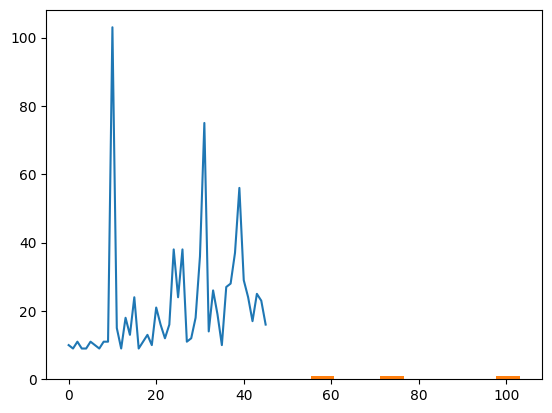

: 

In [3]:
env = CartPoleEnv(n_observations=1000, alpha=0.75)
env.train()
env.test()
plt.plot(env.metric)
print(np.mean(env.metric))
print(np.median(env.metric))
print(np.quantile(env.metric, [0, 0.25, 0.5, 0.75, .95, .99, 0.999, 1]))
plt.hist(env.metric, bins=10, range=[50,np.max(env.metric)])

13.564378730330983
11.0
[  8.  10.  11.  15.  27.  42.  63. 103.]


(array([162.,  80.,  54.,  25.,  13.,   6.,   8.,   2.,   0.,   2.]),
 array([ 50. ,  55.3,  60.6,  65.9,  71.2,  76.5,  81.8,  87.1,  92.4,
         97.7, 103. ]),
 <BarContainer object of 10 artists>)

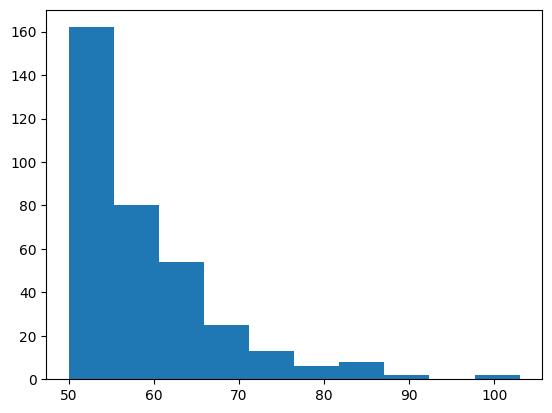

In [84]:
print(np.mean(env.metric))
print(np.median(env.metric))
print(np.quantile(env.metric, [0, 0.25, 0.5, 0.75, .95, .99, 0.999, 1]))
plt.hist(env.metric, bins=10, range=[50,np.max(env.metric)])


In [85]:
np.set_printoptions(threshold=np.inf)
env.q_table

array([[1.00388089, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [22]:
np.nonzero(env_alpha_75.q_table)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([   0, 3511, 3512, 3519, 3520, 3575, 3576, 3583, 3584, 4023, 4024,
        4031, 4032, 4087, 4088, 4095,    0, 3511, 3512, 3519, 3520, 3575,
        3576, 3583, 3584, 4023, 4024, 4031, 4032, 4087, 4088, 4095]))

In [7]:
env = CartPoleEnv()

In [8]:
np.zeros(env.n_observation_space) + 1

array([1., 1., 1., 1.])